In [1]:
# Data Loading
import xarray as xr  

# Data Processing
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Data Load

In [2]:
# data source : https://psl.noaa.gov/data/gridded/data.gpcp.html (precipitation)
#               https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html (SST)
#               https://psl.noaa.gov/data/gridded/data.ncep.reanalysis2.pressure.html (hgt)

path_precip = './precip.mon.mean.nc'
path_sst = './sst.mnmean.nc'
path_hgt = './hgt.mon.mean.nc'

file_precip = xr.open_dataset(path_precip)
file_sst = xr.open_dataset(path_sst)
file_hgt = xr.open_dataset(path_hgt)

# print dataset infomation
print(file_precip)
print(file_sst)
print(file_hgt)

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, nv: 2, time: 496)
Coordinates:
  * lat        (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float32 1.25 3.75 6.25 8.75 ... 351.25 353.75 356.25 358.75
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-04-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] ...
    lat_bnds   (lat, nv) float32 ...
    lon_bnds   (lon, nv) float32 ...
    precip     (time, lat, lon) float32 ...
Attributes:
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    documentation:  

/usr/local/python/2.7/envs/p3.6_cpu/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'hgt' has multiple fill values {-32767, 32766}, decoding all values to NaN.
  use_cftime=use_cftime,


# Data Processing

In [3]:
# select variable
precip = file_precip.data_vars['precip']
sst = file_sst.data_vars['sst']
hgt = file_hgt.data_vars['hgt']

print(precip.shape)
print(sst.shape)
print(hgt.shape)

(496, 72, 144)
(1996, 89, 180)
(496, 17, 73, 144)


In [4]:
# select level (for hgt)
hgt_200mb = hgt.sel(level=200)
print(hgt_200mb.shape)

(496, 73, 144)


In [5]:
# use customized function to make code short
def monthly_anomaly(x):
    climatology = x.groupby("time.month").mean("time")
    anomalies = x.groupby("time.month") - climatology
    return anomalies

# for more useful examples for weather data
# http://xarray.pydata.org/en/stable/examples/weather-data.html

In [6]:
# monthly anomalies
precip_ano = monthly_anomaly(precip)
sst_ano = monthly_anomaly(sst)
hgt200_ano = monthly_anomaly(hgt_200mb)

print(precip_ano.shape)
print(sst_ano.shape)
print(hgt200_ano.shape)

/usr/local/python/2.7/envs/p3.6_cpu/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(496, 72, 144)
(1996, 89, 180)
(496, 73, 144)


In [7]:
# composite El Nino / La Nina years
# https://ggweather.com/enso/oni.htm

elninos = ['1983-01', '1987-01', '1988-01', '1992-01', '1995-01', '1998-01', '2003-01', '2010-01']
laninas = ['1989-01', '1996-01', '1999-01', '2000-01', '2008-01', '2011-01', '2012-01']

for i, elnino in enumerate(elninos):
    if i == 0:
        elnino_precip = precip_ano.sel(time=elnino)[0]/len(elninos)
        elnino_sst    = sst_ano.sel(time=elnino)[0]/len(elninos) 
        elnino_hgt    = hgt200_ano.sel(time=elnino)[0]/len(elninos) 
    else:
        elnino_precip += precip_ano.sel(time=elnino)[0]/len(elninos) 
        elnino_sst    += sst_ano.sel(time=elnino)[0]/len(elninos) 
        elnino_hgt    += hgt200_ano.sel(time=elnino)[0]/len(elninos)
        
for i, lanina in enumerate(laninas):
    if i == 0:
        lanina_precip = precip_ano.sel(time=lanina)[0]/len(laninas)
        lanina_sst    = sst_ano.sel(time=lanina)[0]/len(laninas) 
        lanina_hgt    = hgt200_ano.sel(time=lanina)[0]/len(laninas) 
    else:
        lanina_precip += precip_ano.sel(time=lanina)[0]/len(laninas) 
        lanina_sst    += sst_ano.sel(time=lanina)[0]/len(laninas) 
        lanina_hgt    += hgt200_ano.sel(time=lanina)[0]/len(laninas)

# Visualization

In [8]:
def plot_precip(ax, x, title):
    
    m = Basemap(
        lon_0=0, lat_0=0, # center of mat domain
        llcrnrlon=0., llcrnrlat=-80., urcrnrlon=360., urcrnrlat=80., # projection region
        resolution='l', # boundary resolution (c, l, i, h, f)
        ax=ax
    )
    
    coord = np.meshgrid(x.lon, x.lat)
    m.drawcoastlines(linewidth=0.5, color='k') # draw coastline
    m.drawparallels(np.linspace(-80,80,5), labels=[1,0,0,0], linewidth=0., fontsize=10) # draw horizontal grid line
    m.drawmeridians(np.linspace(0,360,5), labels=[0,0,0,1], linewidth=0., fontsize=10) # draw vertical grid line 
    m.contourf(coord[0], coord[1], x,
               cmap=plt.cm.BrBG,
               levels=20
              )
    
    ax.set_title(title)

In [9]:
def plot_sst(ax, x, title):
    
    m = Basemap(
        lon_0=0, lat_0=0, # center of mat domain
        llcrnrlon=0., llcrnrlat=-80., urcrnrlon=360., urcrnrlat=80., # projection region
        resolution='l', # boundary resolution (c, l, i, h, f)
        ax=ax
    )
    
    coord = np.meshgrid(x.lon, x.lat)
    m.drawcoastlines(linewidth=0.5, color='k') # draw coastline
    m.drawlsmask(land_color='lightgray') # landfill
    m.drawparallels(np.linspace(-80,80,5), labels=[1,0,0,0], linewidth=0., fontsize=10) # draw horizontal grid line
    m.drawmeridians(np.linspace(0,360,5), labels=[0,0,0,1], linewidth=0., fontsize=10) # draw vertical grid line 
    m.contourf(coord[0], coord[1], x,
               cmap=plt.cm.RdYlBu_r,  # reverse colormap order
               levels=20
              )
    
    ax.set_title(title)

In [10]:
def plot_hgt(ax, x, title):
    
    m = Basemap(
        projection = 'ortho',
        lon_0=210, lat_0=20, # center of mat domain
        #llcrnrlon=0., llcrnrlat=-80., urcrnrlon=360., urcrnrlat=80., # projection region
        resolution='l', # boundary resolution (c, l, i, h, f)
        ax=ax
    )
    
    coord = np.meshgrid(x.lon, x.lat)
    lon_c, lat_c = m(coord[0], coord[1])   # converted coordination up to projection 
    m.drawcoastlines(linewidth=0.5, color='k') # draw coastline
    m.contourf(lon_c, lat_c, x,
               cmap=plt.cm.Spectral,  # reverse colormap order
               levels=20
              )
    
    ax.set_title(title)

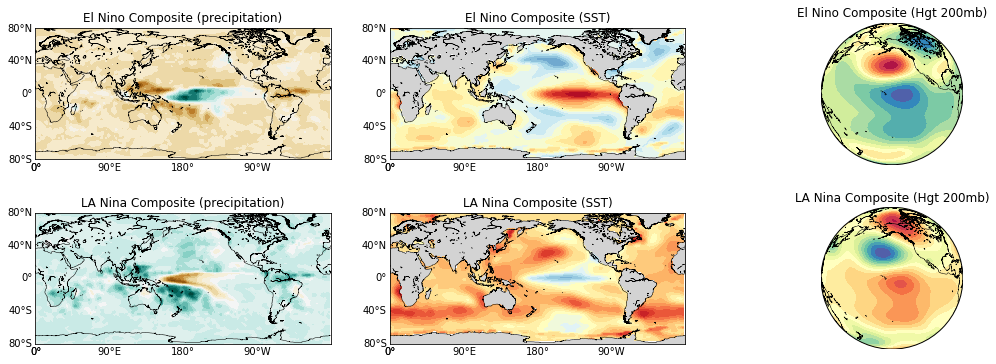

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.2, hspace=0.3)

plot_precip(ax[0][0], elnino_precip, 'El Nino Composite (precipitation)')
plot_precip(ax[1][0], lanina_precip, 'LA Nina Composite (precipitation)')

plot_sst(ax[0][1], elnino_sst, 'El Nino Composite (SST)')
plot_sst(ax[1][1], lanina_sst, 'LA Nina Composite (SST)')

plot_hgt(ax[0][2], elnino_hgt, 'El Nino Composite (Hgt 200mb)')
plot_hgt(ax[1][2], lanina_hgt, 'LA Nina Composite (Hgt 200mb)')